In [889]:
import uproot
import uproot_methods
import pandas

In [1045]:
def pthard(df, objs):
    df["sumHard"] = uproot_methods.TLorentzVector(0.,0.,0.,0.)
    df["sumptHard"] = 0.
    for obj in objs:
        df["sumHard"] += df[obj]
        df["sumptHard"] += df.apply(lambda x: x[obj].pt, axis=1)
    df["RptHard"] = df.apply(lambda x: x["sumHard"].pt/x["sumptHard"], axis=1)
    return df

In [1079]:
def add_Rpthard(df, objs):
    new_df = pandas.DataFrame()
    for obj in objs:
        obj_pt = "%sPt" % obj if ("%sPt" % obj) in df else "%sEt" % obj
        obj_eta = "%sEta" % obj if ("%sEta" % obj) in df else None
        obj_phi = "%sPhi" % obj
        obj_m = "%sMass" % obj if ("%sMass" % obj) in df else None
        print(obj, obj_pt, obj_eta, obj_phi, obj_m)
        new_df[obj] = df.apply(lambda x: uproot_methods.TLorentzVector.from_ptetaphim(x[obj_pt], 
                                                x[obj_eta] if obj_eta else 0, x[obj_phi], (x[obj_m] if obj_m else 0)), axis=1)
    df["RptHard"] = pthard(new_df, objs)["RptHard"]

In [1315]:
def prepareDataset(dataset, chan, drop=[]):
    leps = ["e1", "e2", "e3"]
    if chan == "eem":
        leps = ["e1", "e2", "m"]
    elif chan == "emm":
        leps = ["m1", "m2", "e"]
    elif chan == "mmm":
        leps = ["m1", "m2", "m3"]
        
    readvars = ["jetPt", "jetEta", "jetPhi", "nJets", "Mass", "MTWZ", "mjj", "Eta", "type1_pfMETEt", "type1_pfMETPhi"]
    addPart = lambda x: [x+"Pt", x+"Mass", x+"Eta", x+"Phi"]
    for lep in leps:
        readvars.extend(addPart(lep))
        
    df = dataset[chan]["ntuple"].pandas.df(readvars, flatten=False)
    filtered_df = df[df["mjj"] > 100.].copy()
    filtered_df["j1Pt"] = filtered_df["jetPt"].str[0]
    filtered_df["j2Pt"] = filtered_df["jetPt"].str[1]
    filtered_df["j1Phi"] = filtered_df["jetPhi"].str[0]
    filtered_df["j2Phi"] = filtered_df["jetPhi"].str[1]
    filtered_df["j1Eta"] = filtered_df["jetEta"].str[0]
    filtered_df["j2Eta"] = filtered_df["jetEta"].str[1]
    filtered_df["dEtajj"] = filtered_df["j1Eta"] - filtered_df["j2Eta"]
    filtered_df["dPhijj"] = filtered_df["j1Phi"] - filtered_df["j2Phi"]
    filtered_df["etas3l"] = filtered_df["Eta"] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["etasl1"] = filtered_df["%sEta" % leps[0]] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["etasl2"] = filtered_df["%sEta" % leps[1]] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["etasl3"] = filtered_df["%sEta" % leps[2]] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["zep3l"] = filtered_df["etas3l"]/filtered_df["dEtajj"]
    filtered_df["zepl1"] = filtered_df["etasl1"]/filtered_df["dEtajj"]
    filtered_df["zepl2"] = filtered_df["etasl2"]/filtered_df["dEtajj"]
    filtered_df["zepl3"] = filtered_df["etasl3"]/filtered_df["dEtajj"]
    
    #filtered_df = filtered_df[(filtered_df["mjj"] > 500.) & (abs(filtered_df["dEtajj"]) > 2.5)].copy()
    add_Rpthard(filtered_df, leps+["type1_pfMET", "j1", "j2"])
    
    filtered_df = filtered_df.drop(["jetEta", "jetPt", "jetPhi"], axis=1)
    #default_drop = ["Mass", "MtToMET", "type1_pfMETEt", "nJets", "Eta"]
    default_drop = ["MtToMET", "type1_pfMETPhi", "nJets", "Eta", "etas3l", "etasl1", 
                    "etasl2", "j1Phi", "j2Phi", ]
    for part in leps:
        default_drop.extend(addPart(part))
    drop.extend(default_drop)
    filtered_df = filtered_df.drop(drop, axis=1)
    return filtered_df

In [1061]:
def eventsProcessed(dataset):
    df = dataset["metaInfo"]["metaInfo"].pandas.df()
    return sum(df["summedWeights"])

In [1316]:
qcdwz_file = uproot.open("Data/2018-04-29-wz3lnu-powheg/combined.root")
ewwz_file = uproot.open("Data/2018-04-29-wlljj-ewk-WZxsec2016-3MediumLeptonsNoVetoToWselection-v1/combined.root")
ew_df = pandas.DataFrame()
qcd_df = pandas.DataFrame()
for chan in ["eee", "eem", "emm", "mmm"]:
    ew_df = pandas.concat([ew_df, prepareDataset(ewwz_file, chan, [])])
    qcd_df = pandas.concat([qcd_df, prepareDataset(qcdwz_file, chan, [])])

e1 e1Pt e1Eta e1Phi e1Mass
e2 e2Pt e2Eta e2Phi e2Mass
e3 e3Pt e3Eta e3Phi e3Mass
type1_pfMET type1_pfMETEt None type1_pfMETPhi None
j1 j1Pt j1Eta j1Phi None
j2 j2Pt j2Eta j2Phi None
e1 e1Pt e1Eta e1Phi e1Mass
e2 e2Pt e2Eta e2Phi e2Mass
e3 e3Pt e3Eta e3Phi e3Mass
type1_pfMET type1_pfMETEt None type1_pfMETPhi None
j1 j1Pt j1Eta j1Phi None
j2 j2Pt j2Eta j2Phi None
e1 e1Pt e1Eta e1Phi e1Mass
e2 e2Pt e2Eta e2Phi e2Mass
m mPt mEta mPhi mMass
type1_pfMET type1_pfMETEt None type1_pfMETPhi None
j1 j1Pt j1Eta j1Phi None
j2 j2Pt j2Eta j2Phi None
e1 e1Pt e1Eta e1Phi e1Mass
e2 e2Pt e2Eta e2Phi e2Mass
m mPt mEta mPhi mMass
type1_pfMET type1_pfMETEt None type1_pfMETPhi None
j1 j1Pt j1Eta j1Phi None
j2 j2Pt j2Eta j2Phi None
m1 m1Pt m1Eta m1Phi m1Mass
m2 m2Pt m2Eta m2Phi m2Mass
e ePt eEta ePhi eMass
type1_pfMET type1_pfMETEt None type1_pfMETPhi None
j1 j1Pt j1Eta j1Phi None
j2 j2Pt j2Eta j2Phi None
m1 m1Pt m1Eta m1Phi m1Mass
m2 m2Pt m2Eta m2Phi m2Mass
e ePt eEta ePhi eMass
type1_pfMET type1_pfMETEt Non

In [1318]:
qcd_df["isSignal"] = -1
qcd_df

,Mass,mjj,type1_pfMETEt,j1Pt,j2Pt,j1Eta,j2Eta,dEtajj,dPhijj,etasl3,zep3l,zepl1,zepl2,zepl3,RptHard,isSignal
entry,,,,,,,,,,,,,,,,
7,197.474213,1452.079590,56.381241,289.282349,90.630432,-1.126147,3.234876,-4.361023,-3.363071,-2.389761,0.425171,0.196221,0.283425,0.547982,0.068448,-1
9,187.145844,538.557129,77.485161,104.530663,53.914455,1.259367,-2.700934,3.960301,5.335135,1.795126,0.434817,0.262619,0.327529,0.453280,0.125928,-1
21,147.425415,166.633636,42.591873,59.698605,36.747917,1.257995,3.679656,-2.421661,-2.186565,-0.643077,-0.060248,0.655672,0.724572,0.265552,0.221120,-1
22,154.552063,248.347427,144.693771,270.434143,85.779564,-0.087381,-0.261261,0.173881,-4.430906,0.768294,5.338115,1.397599,3.478351,4.418507,0.042732,-1
35,155.078537,1854.938965,65.275612,130.573730,111.357719,-3.381214,2.092694,-5.473908,-5.953694,2.113998,-0.225061,-0.218394,-0.115776,-0.386195,0.156307,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184338,126.538589,302.836609,36.802418,86.039040,30.506975,1.076493,-2.413027,3.489520,3.362889,1.360771,0.712164,0.654876,0.623139,0.389959,0.017725,-1
184343,126.448036,396.767975,85.008743,143.450394,33.921539,-0.282596,-3.680607,3.398010,-2.357022,3.000904,0.986681,0.938407,0.371488,0.883136,0.072817,-1
184349,661.758911,1305.660278,71.650558,319.437012,44.154739,-1.928186,2.867761,-4.795947,-1.434279,0.611581,-0.053570,0.291198,0.440389,-0.127520,0.022967,-1


In [1319]:
ew_df["isSignal"] = 1
ew_df

,Mass,mjj,type1_pfMETEt,j1Pt,j2Pt,j1Eta,j2Eta,dEtajj,dPhijj,etasl3,zep3l,zepl1,zepl2,zepl3,RptHard,isSignal
entry,,,,,,,,,,,,,,,,
1,231.138519,744.512634,70.754158,244.329880,70.080750,0.964082,-2.448253,3.412335,-2.880494,-0.195692,0.128274,0.348781,0.351788,-0.057349,0.032473,1
2,346.155365,1094.974487,102.971786,116.069794,36.278889,3.470814,-2.176313,5.647127,2.115696,0.806820,0.287652,0.148424,0.295892,0.142873,0.037136,1
3,264.256012,566.254272,95.062729,362.949463,43.012203,-2.759324,0.269961,-3.029285,-1.365894,0.859827,-0.677175,-0.730590,-0.570534,-0.283838,0.053319,1
4,288.859344,102.392677,42.641720,275.542755,94.206352,-2.399656,-2.497308,0.097651,0.577392,3.370017,26.083177,26.387960,22.091526,34.510742,0.097443,1
5,130.684494,1426.736206,255.066833,254.638641,56.844784,1.564925,-3.387091,4.952016,1.101611,1.084220,0.335833,0.239789,0.346027,0.218945,0.050498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38931,549.119568,665.170044,67.633163,492.240631,148.574539,-0.191494,1.224140,-1.415634,2.547495,-1.511534,0.610934,-1.193107,0.650190,1.067743,0.079867,1
38932,143.280563,549.855103,79.507683,397.701080,94.984352,-0.545479,1.218699,-1.764178,3.496532,-0.694640,0.594475,0.759561,0.144066,0.393747,0.059552,1
38934,280.429840,1536.218506,109.654442,127.344757,71.345322,1.629912,-3.927989,5.557900,1.707636,0.269949,0.550082,0.471582,0.464335,0.048570,0.061506,1


In [1320]:
full_df = pandas.concat([ew_df, qcd_df], sort=False)
truth_df = full_df["isSignal"]
train_full_df = full_df.drop(["isSignal"], axis=1)
full_df

,Mass,mjj,type1_pfMETEt,j1Pt,j2Pt,j1Eta,j2Eta,dEtajj,dPhijj,etasl3,zep3l,zepl1,zepl2,zepl3,RptHard,isSignal
entry,,,,,,,,,,,,,,,,
1,231.138519,744.512634,70.754158,244.329880,70.080750,0.964082,-2.448253,3.412335,-2.880494,-0.195692,0.128274,0.348781,0.351788,-0.057349,0.032473,1
2,346.155365,1094.974487,102.971786,116.069794,36.278889,3.470814,-2.176313,5.647127,2.115696,0.806820,0.287652,0.148424,0.295892,0.142873,0.037136,1
3,264.256012,566.254272,95.062729,362.949463,43.012203,-2.759324,0.269961,-3.029285,-1.365894,0.859827,-0.677175,-0.730590,-0.570534,-0.283838,0.053319,1
4,288.859344,102.392677,42.641720,275.542755,94.206352,-2.399656,-2.497308,0.097651,0.577392,3.370017,26.083177,26.387960,22.091526,34.510742,0.097443,1
5,130.684494,1426.736206,255.066833,254.638641,56.844784,1.564925,-3.387091,4.952016,1.101611,1.084220,0.335833,0.239789,0.346027,0.218945,0.050498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184338,126.538589,302.836609,36.802418,86.039040,30.506975,1.076493,-2.413027,3.489520,3.362889,1.360771,0.712164,0.654876,0.623139,0.389959,0.017725,-1
184343,126.448036,396.767975,85.008743,143.450394,33.921539,-0.282596,-3.680607,3.398010,-2.357022,3.000904,0.986681,0.938407,0.371488,0.883136,0.072817,-1
184349,661.758911,1305.660278,71.650558,319.437012,44.154739,-1.928186,2.867761,-4.795947,-1.434279,0.611581,-0.053570,0.291198,0.440389,-0.127520,0.022967,-1


In [1321]:
from sklearn.model_selection import train_test_split
testsize=0.5
X_train, X_test, y_train, y_test = train_test_split(full_df, truth_df, test_size=testsize, random_state=42)
X_test_ew = X_test[X_test["isSignal"] > 0]
X_test_qcd = X_test[X_test["isSignal"] < 0]
X_train = X_train.drop(["isSignal"], axis=1)
X_test = X_test.drop(["isSignal"], axis=1)
X_test_qcd = X_test_qcd.drop(["isSignal"], axis=1)
X_test_ew = X_test_ew.drop(["isSignal"], axis=1)

In [178]:
import xgboost as xgb

28289

In [1322]:
mod = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=8,
    n_estimators=800,                                                                    
    min_samples_leaf=800
)

In [369]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
mod = AdaBoostRegressor(
    learning_rate=0.01,
    n_estimators=10000
)

In [1323]:
mod.fit(X_train, y_train)

[02:12:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=1, min_samples_leaf=800,
             missing=None, n_estimators=800, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [1279]:
ew_df[(ew_df["mjj"] > 500) & (abs(ew_df["dEtajj"]) > 2.5)]

,Mass,mjj,dEtajj,dPhijj,zep3l,zepl1,zepl2,zepl3,RptHard,isSignal
entry,,,,,,,,,,
1,231.138519,744.512634,3.412335,-2.880494,0.128274,0.348781,0.351788,-0.057349,0.032473,1
2,346.155365,1094.974487,5.647127,2.115696,0.287652,0.148424,0.295892,0.142873,0.037136,1
3,264.256012,566.254272,-3.029285,-1.365894,-0.677175,-0.730590,-0.570534,-0.283838,0.053319,1
5,130.684494,1426.736206,4.952016,1.101611,0.335833,0.239789,0.346027,0.218945,0.050498,1
6,215.936279,1171.368896,-5.660201,3.110194,-0.092905,-0.197651,0.181179,0.202823,0.107325,1
...,...,...,...,...,...,...,...,...,...,...
38923,117.531509,649.142517,-4.164258,2.480447,0.120582,0.092266,0.382250,0.247771,0.131112,1
38924,435.111298,1360.589966,-6.255398,-3.344548,0.397274,0.309476,0.380670,-0.339758,0.058618,1
38926,223.504883,2351.988525,5.302805,-1.303780,0.067941,0.083788,-0.019034,0.181708,0.181675,1


In [1208]:
qcd_df[(qcd_df["mjj"] > 500) & (abs(qcd_df["dEtajj"]) > 2.5)]

,Mass,mjj,dEtajj,dPhijj,zep3l,zepl1,zepl2,zepl3,isSignal
entry,,,,,,,,,
7,197.474213,1452.079590,-4.361023,-3.363071,0.425171,0.196221,0.283425,0.547982,-1
9,187.145844,538.557129,3.960301,5.335135,0.434817,0.262619,0.327529,0.453280,-1
35,155.078537,1854.938965,-5.473908,-5.953694,-0.225061,-0.218394,-0.115776,-0.386195,-1
62,166.617630,1085.171997,-5.614026,2.526582,0.137488,0.168870,0.091427,0.215964,-1
106,264.812683,509.333130,3.546308,2.469148,0.387964,0.206736,0.076470,0.041893,-1
...,...,...,...,...,...,...,...,...,...
184302,231.382065,849.562744,3.912439,2.067925,0.186587,0.217684,0.121030,0.239130,-1
184306,355.679535,587.116943,2.573841,-1.741639,1.016745,0.428512,0.853271,1.066267,-1
184308,235.873291,705.754639,-6.026328,3.073542,0.492874,-0.015424,0.066787,0.233237,-1


In [1324]:
X_test_ew_wcut = X_test_ew[(abs(X_test_ew["dEtajj"]) > 2.5) & (X_test_ew["mjj"] > 500)]
X_test_qcd_wcut = X_test_qcd[(abs(X_test_qcd["dEtajj"]) > 2.5) & (X_test_qcd["mjj"] > 500)]
predictions_ew = mod.predict(X_test_ew_wcut)
predictions_qcd = mod.predict(X_test_qcd_wcut)
#predictions_ew = mod.predict(X_test_ew)
#predictions_qcd = mod.predict(X_test_qcd)
print(len(predictions_ew))
print(len(predictions_qcd))

27287
7115


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


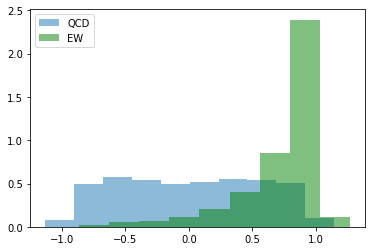

In [1325]:
plt.hist(predictions_qcd,alpha=0.5, label='QCD', normed=True)
plt.hist(predictions_ew,color='g', alpha=0.5,label='EW', normed=True)
plt.legend()

In [1259]:
predictions = mod.predict(X_test)
len(predictions)

14636

In [342]:
import matplotlib.pyplot as plt

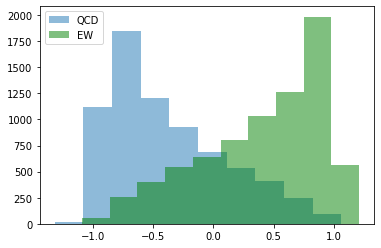

In [1260]:
plt.hist(predictions_qcd,alpha=0.5, label='QCD')
plt.hist(predictions_ew,color='g', alpha=0.5,label='EW')
plt.legend()

In [265]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import numpy

In [1261]:
cutoff = 0.0
cat_predict = [1 if x > cutoff else -1 for x in predictions] 
print("Roc score is", roc_auc_score(cat_predict, y_test))

Roc score is 0.7732336632927821


In [1262]:
tn, fp, fn, tp = confusion_matrix(cat_predict, y_test).ravel()
print(confusion_matrix(cat_predict, y_test))
tot_qcd = len(predictions_qcd)
print("\nTotal QCD", tot_qcd)
print("-------------------------------")
print("QCD as QCD", tn, "(%0.02f percent)" % (tn/tot_qcd*100))
print("QCD as EW", fp, "(%0.02f percent)" % (fp/tot_qcd*100))

tot_ew = len(predictions_ew)
print("\nTotal EW", tot_ew)
print("-------------------------------")
print("EW as QCD", fn, "(%0.02f percent)" % (fn/tot_ew*100))
print("EW as EW", tp, "(%0.02f percent)" % (tp/tot_ew*100))
print("-------------------------------")
print("Overall accuracy", accuracy_score(cat_predict, y_test))

[[5508 1731]
 [1586 5811]]

Total QCD 7094
-------------------------------
QCD as QCD 5508 (77.64 percent)
QCD as EW 1731 (24.40 percent)

Total EW 7542
-------------------------------
EW as QCD 1586 (21.03 percent)
EW as EW 5811 (77.05 percent)
-------------------------------
Overall accuracy 0.7733670401749112


In [1263]:
cutoff = 0.5
print("Rate of acceptance")
acc_rate_sig = len([x for x in filter(lambda x: x > cutoff, predictions_ew)])/(eventsProcessed(ewwz_file)*testsize)
acc_rate_bkgd = len([x for x in filter(lambda x: x > cutoff, predictions_qcd)])/(eventsProcessed(qcdwz_file)*testsize)
#acc_bkgd = testqcd_emm_wtruth[testqcd_emm_wtruth["prediction"] > 0.9]
print("Signal", acc_rate_sig)
print("Background", acc_rate_bkgd)

Rate of acceptance
Signal 0.007778
Background 4.8778759987248704e-05


In [1264]:
print("Scaled by cross section and 36 fb-1")
print("Signal", acc_rate_sig*17.5*36)
print("Background", acc_rate_bkgd*4.43*1000*36)

Scaled by cross section and 36 fb-1
Signal 4.90014
Background 7.779236642766423


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


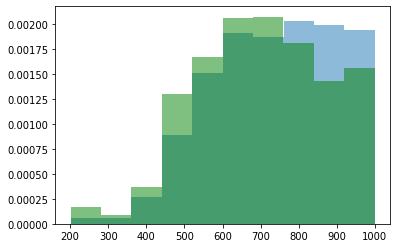

In [1174]:
X_test_ew["predict"] = predictions_ew
X_test_qcd["predict"] = predictions_qcd
ewklike = X_test_ew[(X_test_ew["predict"] > 0.5) & (X_test_ew["mjj"] < 1000)]
ewklike_qcd = X_test_qcd[(X_test_qcd["predict"] > 0.5) & (X_test_qcd["mjj"] < 1000)]
plt.hist(ewklike["mjj"],alpha=0.5, label='EW', normed=True)
plt.hist(ewklike_qcd["mjj"],color='g', alpha=0.5,label='EW', normed=True)
plt.show()

In [516]:
import numpy as np

In [1196]:
ewhist, bins = np.histogram(predictions_ew, bins=[0, 0.5, 0.6, 0.7, 0.8, 0.9, 2])
qcdhist, bins = np.histogram(predictions_qcd, bins=[0, 0.5, 0.6, 0.7, 0.8, 0.9, 2])
ewhist = ewhist*17.6*36/(eventsProcessed(ewwz_file)/2)
qcdhist = qcdhist*4430*36/(eventsProcessed(qcdwz_file)/2)
print(ewhist)
print(qcdhist)
print(17.6*36/eventsProcessed(ewwz_file))
print(4430*36/eventsProcessed(qcdwz_file))

[11.2540032  3.1084416  3.8041344  5.0675328  7.4460672 13.584384 ]
[85.08741822 11.26536759  9.61913909  8.84444332  6.53649552  3.16334104]
0.0006336
0.008069747554736955


6
7


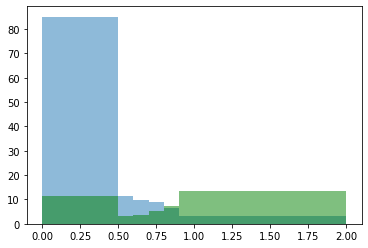

In [1197]:
plt.hist(bins[:-1], weights=qcdhist, bins=bins, alpha=0.5)
plt.hist(bins[:-1], weights=ewhist, bins=bins,color='g', alpha=0.5)
print(len(ewhist))
print(len(bins))

In [1198]:
ew_processed = eventsProcessed(ewwz_file)
qcd_processed = eventsProcessed(qcdwz_file)
print(len(ew_df))
print(len(ew_df[(ew_df.mjj > 500) & (abs(ew_df.dEtajj) > 2.5)]))
print(len(ew_df[(ew_df.mjj > 500) & (abs(ew_df.dEtajj) > 2.5)])/ew_processed*17.6*36)

print("\n", len(qcd_df))
print(len(qcd_df[(qcd_df.mjj > 500) & (abs(qcd_df.dEtajj) > 2.5)]))
print(len(qcd_df[(qcd_df.mjj > 500) & (abs(qcd_df.dEtajj) > 2.5)])/qcd_processed*4300*36)

85567
54953
34.818220800000006

 56483
14271
111.78385544485317


In [602]:
qcd_processed

1000000.0

In [1097]:
import math
def approxLikelihood(sig_hist, bkgd_hist):
    term1 = 0
    term2 = 0
    for sig, bkgd in zip(sig_hist, bkgd_hist):
        term1 += (sig+bkgd)*math.log(1+sig/bkgd)
        term2 += sig
    return math.sqrt(2*(term1 - term2))

In [1199]:
print(approxLikelihood(ewhist, qcdhist))

6.4070129437731556


In [1106]:
ew_loose = ew_df[(ew_df.mjj > 500) & (abs(ew_df.dEtajj) > 2.5)]
qcd_loose = qcd_df[(qcd_df.mjj > 500) & (abs(qcd_df.dEtajj) > 2.5)]
ew_mjj_hist,bins = numpy.histogram(ew_loose["mjj"], bins=[500,750,1000, 1250, 1500, 2000, 10000])
qcd_mjj_hist,bins = numpy.histogram(qcd_loose["mjj"], bins=[500,750,1000, 1250, 1500, 2000, 10000])
ew_mjj_hist = ew_mjj_hist*17.6*36/eventsProcessed(ewwz_file)
qcd_mjj_hist = qcd_mjj_hist*4300*36/eventsProcessed(qcdwz_file)

(array([6.8751936, 6.266304 , 5.1410304, 4.0746816, 5.4540288, 7.0063488]),
 array([  500,   750,  1000,  1250,  1500,  2000, 10000]),
 <a list of 6 Patch objects>)

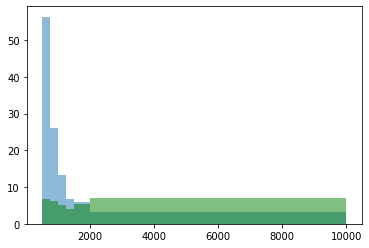

In [1107]:
plt.hist(bins[:-1], weights=qcd_mjj_hist, bins=bins, alpha=0.5)
plt.hist(bins[:-1], weights=ew_mjj_hist, bins=bins, alpha=0.5, color='g')

In [1108]:
print(approxLikelihood(ew_mjj_hist, qcd_mjj_hist))
len(ew_mjj_hist)

4.438671382301406


6

In [1200]:
print(approxLikelihood(ewhist, qcdhist)/approxLikelihood(ew_mjj_hist, qcd_mjj_hist))

1.4434528695501636


In [787]:
print("Processed QCD", qcd_processed)
print("Accepted loose QCD", len(qcd_loose))

Processed QCD 19762700.0
Accepted loose QCD 14271


In [1113]:
ew_bdt = X_test_ew[(X_test_ew.mjj > 500) & (abs(X_test_ew.dEtajj) > 2.5)]
ew_bdt = X_test_qcd[(X_test_qcd.mjj > 500) & (abs(X_test_qcd.dEtajj) > 2.5)]
ew_bdtTight_hist,bins = numpy.histogram(X_test_ew["predict"])
qcd_bdtTight_hist,bins = numpy.histogram(X_test_qcd["predict"])
#ew_bdtTight_hist = ew_bdtTight_hist*17.6*36/(eventsProcessed(ewwz_file)*testsize)
#qcd_bdtTight_hist = qcd_bdtTight_hist*4300*36/(eventsProcessed(qcdwz_file)*testsize)

(array([ 377., 4037., 5848., 5419., 4131., 3050., 2252., 1518., 1213.,
         444.]),
 array([-1.2172543 , -0.98875153, -0.7602488 , -0.53174603, -0.30324328,
        -0.07474053,  0.15376222,  0.38226497,  0.6107677 ,  0.8392705 ,
         1.0677732 ], dtype=float32),
 <a list of 10 Patch objects>)

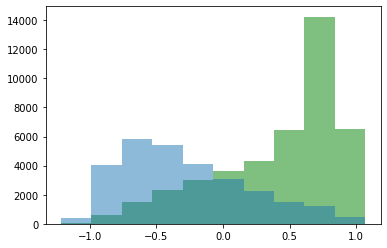

In [1114]:
plt.hist(bins[:-1], weights=ew_bdtTight_hist, bins=bins, alpha=0.5, color='g', label='EW')
plt.hist(bins[:-1], weights=qcd_bdtTight_hist, bins=bins, alpha=0.5, label='QCD')

In [1118]:
bins=[0,250,500,1000,1250,1500,3000]
ew_mjj_bdtTight_hist,bins = numpy.histogram(X_test_ew[X_test_ew.predict > 0.5]["mjj"], bins=bins)
qcd_mjj_bdtTight_hist,bins = numpy.histogram(X_test_qcd[X_test_qcd.predict > 0.5]["mjj"], bins=bins)
ew_mjj_bdtTight_hist = ew_mjj_bdtTight_hist*17.6*36/(eventsProcessed(ewwz_file)*testsize)
qcd_mjj_bdtTight_hist = qcd_mjj_bdtTight_hist*4300*36/(eventsProcessed(qcdwz_file)*testsize)

(array([ 0.125327  ,  3.46215851, 19.09670237,  5.51438822,  3.02351399,
         4.84075556]),
 array([   0,  250,  500, 1000, 1250, 1500, 3000]),
 <a list of 6 Patch objects>)

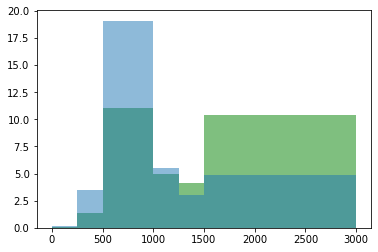

In [1119]:
plt.hist(bins[:-1], weights=ew_mjj_bdtTight_hist, bins=bins, alpha=0.5, color='g', label='EW')
plt.hist(bins[:-1], weights=qcd_mjj_bdtTight_hist, bins=bins, alpha=0.5, label='QCD')

In [1120]:
bins=[0,1,2,3,4,5,6]
ew_etajj_bdtTight_hist,bins = numpy.histogram(abs(X_test_ew[X_test_ew.predict > 0.5]["dEtajj"]), bins=bins)
qcd_etajj_bdtTight_hist,bins = numpy.histogram(abs(X_test_qcd[X_test_qcd.predict > 0.5]["dEtajj"]), bins=bins)
ew_etajj_bdtTight_hist = ew_etajj_bdtTight_hist*17.6*36/(eventsProcessed(ewwz_file)*testsize)
qcd_etajj_bdtTight_hist = qcd_etajj_bdtTight_hist*4300*36/(eventsProcessed(qcdwz_file)*testsize)

(array([1.09661129, 3.55615376, 7.75460843, 9.57185   , 7.89560131,
        4.21412054]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

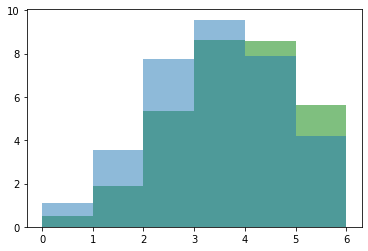

In [1121]:
plt.hist(bins[:-1], weights=ew_etajj_bdtTight_hist, bins=bins, alpha=0.5, color='g', label='EW')
plt.hist(bins[:-1], weights=qcd_etajj_bdtTight_hist, bins=bins, alpha=0.5, label='QCD')